In [53]:
import numpy as np
import matplotlib.pyplot as plt
import descartes
import pandas as pd
import geopandas as gpd
import pyproj
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

In [16]:
heir_prop_data = pd.read_csv('/Users/mkshah605/Downloads/Heir Properties.xlsx - Sheet1.csv')

shapefile = gpd.read_file('/Users/mkshah605/Downloads/cb_2019_37_cousub_500k/cb_2019_37_cousub_500k.shp')
shapefile = shapefile.to_crs({'init': 'epsg:4326'})

In [79]:
heir_prop_data

,PID,MAPID,MAPIDKEY,OBJECTID,OWNER_NUM,OWNER_STREET,OWNER_STREETTYPE,OWNER_DIR,OWNER_UNITDESC,OWNER_UNITNO,...,APRTOT,OBYVAL,XCOORD,YCOORD,Address,location,point,latitude,longitude,altitude
0,R01110-004-010-000,323214.33.3097.000,323214.33.3097,63802269,104,VOLK,DR,NaN,NaN,NaN,...,111600.0,237.0,2333398,223072,"104, VOLK, DR, CASTLE HAYNE, NC, 28429","(104, Volk Drive, Castle Hayne, New Hanover Co...","(34.357954604844345, -77.89569364041606, 0.0)",34.357955,-77.895694,0.0
1,R02519-001-014-000,322014.43.2953.000,322014.43.2953,63823036,2516,ROCK HILL,RD,NaN,NaN,NaN,...,113300.0,0.0,2324258,203932,"2516, ROCK HILL, RD, CASTLE HAYNE, NC, 28429",None,None,NaN,NaN,NaN
2,R02900-003-023-000,327009.06.2936.000,327009.06.2936,63825607,313,APPLE,RD,NaN,NaN,NaN,...,86400.0,0.0,2370231,206961,"313, APPLE, RD, CASTLE HAYNE, NC, 28429",None,None,NaN,NaN,NaN
3,R01905-001-006-000,324109.27.3400.000,324109.27.3400,63837275,3708,SONDEY,RD,NaN,NaN,NaN,...,18900.0,0.0,2342304,217405,"3708, SONDEY, RD, CASTLE HAYNE, NC, 28429",None,None,NaN,NaN,NaN
4,R02513-001-009-000,321016.84.1633.000,321016.84.1633,63840719,14,STONEY,RD,NaN,NaN,NaN,...,96500.0,0.0,2318136,204637,"14, STONEY, RD, CASTLE HAYNE, NC, 28429",None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,R06308-025-006-000,316606.38.9864.000,316606.38.9864,63818152,2209,WAVERLY,DR,NaN,NaN,NaN,...,817500.0,1174.0,2363964,168841,"2209, WAVERLY, DR, WILMINGTON, NC, 28403",None,None,NaN,NaN,NaN
1466,R07600-006-005-002,313305.18.5694.000,313305.18.5694,63780475,3702,MASONBORO LOOP,RD,NaN,NaN,NaN,...,NaN,NaN,2331593,138649,"3702, MASONBORO LOOP, RD, WILMINGTON, NC, 28409","(3702, Masonboro Loop Road, Millbrook, Wilming...","(34.174801037435614, -77.86200050930285, 0.0)",34.174801,-77.862001,0.0
1467,R07600-006-005-003,313305.18.7606.000,313305.18.7606,63844195,3702,MASONBORO LOOP,RD,NaN,NaN,NaN,...,NaN,NaN,2331593,138649,"3702, MASONBORO LOOP, RD, WILMINGTON, NC, 28409","(3702, Masonboro Loop Road, Millbrook, Wilming...","(34.174801037435614, -77.86200050930285, 0.0)",34.174801,-77.862001,0.0
1468,R07600-006-005-001,313305.18.4692.000,313305.18.4692,63872253,3702,MASONBORO LOOP,RD,NaN,NaN,NaN,...,NaN,NaN,2331593,138649,"3702, MASONBORO LOOP, RD, WILMINGTON, NC, 28409","(3702, Masonboro Loop Road, Millbrook, Wilming...","(34.174801037435614, -77.86200050930285, 0.0)",34.174801,-77.862001,0.0


<Figure size 1440x576 with 0 Axes>

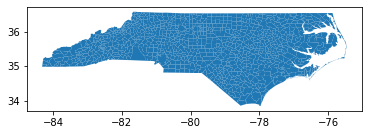

In [15]:
# Trying to see what a shapefile would look like with this, but this is the wrong one

fig = plt.figure(figsize=(20, 8)) 
ax = shapefile.plot()

In [72]:
heir_prop_data['OWNER_NUM'] = heir_prop_data['OWNER_NUM'].astype('Int64')
heir_prop_data['OWNER_ZIP'] = heir_prop_data['OWNER_ZIP'].astype('Int64')

In [73]:
# Concat address fields to make an Address column

heir_prop_data['Address']  = heir_prop_data['OWNER_NUM'].map(str)  + ', ' + heir_prop_data['OWNER_STREET']  + ', ' + heir_prop_data['OWNER_STREETTYPE']  + ', ' + heir_prop_data['OWNER_CITY']  + ', ' + heir_prop_data['OWNER_STATE'] + ', ' + heir_prop_data['OWNER_ZIP'].map(str)

In [59]:
len(heir_prop_data)

1470

In [77]:
# 1 - conveneint function to delay between geocoding calls

locator = Nominatim(user_agent= 'myGeocoder')

geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 2- - create location column
     # I did it like this so I can see the progress as it goes, because it does take a while

heir_prop_data['location'] = 0
for i in range(len(heir_prop_data)):
    heir_prop_data['location'][i] = geocode(heir_prop_data['Address'][i])
    print(i)
    
#heir_prop_data['location'] = heir_prop_data['Address'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
heir_prop_data['point'] = heir_prop_data['location'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
heir_prop_data[['latitude', 'longitude', 'altitude']] = pd.DataFrame(heir_prop_data['point'].tolist(), index=heir_prop_data.index)

<ipython-input-77-ca89859c41a5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heir_prop_data['location'][i] = geocode(heir_prop_data['Address'][i])
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Applications/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72


RateLimiter caught an error, retrying (0/2 tries). Called with (*('711, 11, ST, NEW YORK, NY, 10009',), **{}).
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Applications/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 1322, in getresponse
    response.begin()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Applications/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File

RateLimiter swallowed an error after 2 retries. Called with (*('711, 11, ST, NEW YORK, NY, 10009',), **{}).
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Applications/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 1322, in getresponse
    response.begin()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/Applications/anaconda3/lib/python3.8/http/client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/Applications/anaconda3/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "/

73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329

In [80]:
heir_prop_data.to_csv('/Users/mkshah605/Downloads/Heir_Properties_Geocoded.csv')